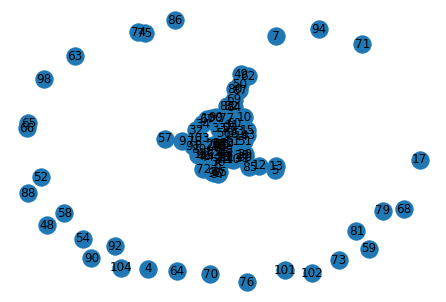

In [12]:
# libraries import
import os
import re
import json
import random
import itertools
import networkx as nx
from scipy.stats import bernoulli

# fetching all the files
base_path = 'sequences/'
files = os.listdir(base_path)

# creating the Graph using networkx
G = nx.Graph()
node_index = 0

# main loop for graph construction
i = 0 # testing with just 1000 files
#for file in files:
while i < 500:
    # opening current file
    # print(files[i])
    with open(base_path + files[i]) as in_file:
        data = json.load(in_file)
    i += 1
    # isolating the comment section
    if 'comment' in data['results'][0]:
        comments_section = data['results'][0]['comment']

        # isolating the authors
        authors = []
        for comment in comments_section:
            pattern = '(_([a-zA-Z]+\.?\s?)*_)'
            results = re.findall(pattern, comment)
            if results:
                author = results[0][0].split('_')[1]
                authors.append(author)

        # adding the nodes
        for author in authors:
            if author not in nx.get_node_attributes(G, 'name').values():
                G.add_node(node_index, name = author)
                node_index += 1

        # adding the edges
        for pair in itertools.combinations(authors, 2):
            # fetching node 1
            node_1_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[0])
            # fetching node 2
            node_2_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[1])
            # adding the edge if it isn't already in the graph
            if (node_1_key, node_2_key) not in list(G.edges):
                G.add_edge(node_1_key, node_2_key)

nx.draw(G, with_labels = True)

In [13]:
#Initialize I to an empty set.
#While V is not empty:
#Choose a node v∈V;
#Add v to the set I;
#Remove from V the node v and all its neighbours.
#Return I.

Greedy algorithm O(m) for finding a MIS

In [14]:
def greedy_MIS(G):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        node = random.choice(V_set)
        maximal_independent_set.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return maximal_independent_set

Greedy algorithm O(m) for finding a MIS with the specified nodes in it

In [85]:
# function that returns a MIS with the specified nodes in it
def greedy_MIS_with_nodes_specified(G, chosen_nodes):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    if check_if_set_is_IS(G, chosen_nodes):
        # inserting the chosen nodes and removing their adj list
        for node in chosen_nodes:
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
        # main loop
        while len(V_set) > 0:
            node = random.choice(V_set)
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
    return maximal_independent_set

Luby's algorithm O(logn) for finding a MIS

In [15]:
def luby_MIS(G):
    V_set = list(G.nodes).copy()
    E_set = list(G.edges).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        probability_dist = [1/(2*G.degree[node]) if G.degree[node] > 0 else 1 for node in V_set]
        marks = bernoulli.rvs(probability_dist, size = len(V_set))
        zip_iter = zip(V_set, marks)
        marked_nodes = dict(zip_iter)
        for edge in E_set:
            if marked_nodes[edge[0]] == 1 and marked_nodes[edge[1]] == 1:
                if G.degree[edge[0]] < G.degree[edge[1]]:
                    marked_nodes[edge[0]] = 0
                elif G.degree[edge[0]] > G.degree[edge[1]]:
                    marked_nodes[edge[1]] = 0
                else:
                    if edge[0] < edge[1]:
                        marked_nodes[edge[0]] = 0
                    else:
                        marked_nodes[edge[1]] = 0
        for idx, node in enumerate(V_set):
            if marked_nodes[idx] == 1:
                maximal_independent_set.append(node)
        for node in maximal_independent_set:
            V_set.remove(node)
            for adj_node in G.adj[node]:
                if adj_node in V_set:
                    V_set.remove(adj_node)
        for edge in E_set:
            if not(edge[0] in V_set and edge[1] in V_set):
                E_set.remove(edge)
    return maximal_independent_set

Algorithm designed to find all MISs

In [30]:
# function that returns true if the set is independent (no 2 vertex build an edge of G)
def check_if_set_is_IS(G, IS):
    pairs = itertools.permutations(IS, 2)
    if any([pair in list(G.edges) for pair in pairs]):
        return False
    else:
        return True

In [16]:
# function that returns true if the independent set is maximal (non-extendible)
def check_if_set_is_MIS(G, IS):
    for node in list(G.nodes):
        IS_with_new_node = IS.copy()
        if node not in IS:
            IS_with_new_node.append(node)
            pairs = itertools.permutations(IS_with_new_node, 2)
            if not any([pair in list(G.edges) for pair in pairs]):
                return False
    return True

In [27]:
# function that returns true if the node we're trying to add doesn't turn the set into
# a dependent set
def is_node_addable_to_IS(G, IS, node):
    IS_with_new_node = IS.copy()
    if node not in IS_with_new_node:
        IS_with_new_node.append(node)
        pairs = itertools.permutations(IS_with_new_node, 2)
        if any([pair in list(G.edges) for pair in pairs]):
            return False
        else:
            return True

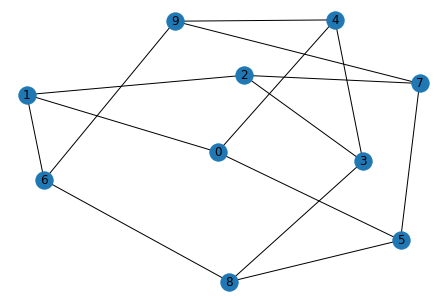

In [36]:
Gp = nx.petersen_graph()
nx.draw(Gp, with_labels = True)

In [88]:
greedy_MIS_with_nodes_specified(Gp, [2,9])

[2, 9, 8, 0]

In [144]:
def find_all_MIS_rec(G, V_set, remaining_nodes, used_nodes, set_of_found_MIS):
    print(V_set)
    if set(used_nodes) == set(list(G.nodes)):
        return
    for node in remaining_nodes:
        used_nodes.append(node)
        if is_node_addable_to_IS(G, V_set, node):
            V_set.append(node)
            if check_if_set_is_MIS(G, V_set):
                set_of_found_MIS.append(V_set)
                V_set.remove(node)
                remaining_nodes.remove(node)
                del V_set[-1]
            find_all_MIS_rec(G, V_set, remaining_nodes, used_nodes, set_of_found_MIS)

In [145]:
def find_all_MIS(G):
    set_of_found_MIS = []
    for node in list(G.nodes):
        print(node)
        V_set = []
        remaining_nodes = list(G.nodes).copy()
        used_nodes = []
        V_set.append(node)
        find_all_MIS_rec(G, V_set, remaining_nodes, used_nodes, set_of_found_MIS)
    return set_of_found_MIS

In [146]:
find_all_MIS(Gp)

0
[0]
[0, 2]
[0]
[0, 2]
[0, 2, 8]
[0, 2]
[0, 2, 8]
1
[1]
[1, 3]
[1, 3, 5]
[1, 3]
[1]
[1, 4]
[1]
[1, 8]
2
[2]
[2, 0]
[2]
[2, 0]
[2, 0, 8]
[2, 0]
[2, 0, 8]
3
[3]
[3, 0]
[3, 0, 6]
[3, 0]
[3, 0, 6]
4
[4]
[4, 1]
[4]
[4, 1]
[4, 1, 7]
[4, 1]
[4, 1, 7]
5
[5]
[5, 1]
[5, 1, 3]
[5, 1]
[5]
[5, 6]
[5, 6, 2]
6
[6]
[6, 0]
[6]
[6, 0]
[6, 0, 3]
[6, 0]
[6, 0, 3]
7
[7]
[7, 0]
[7, 0, 3]
[7, 0]
[7, 0, 3]
8
[8]
[8, 0]
[8, 0, 2]
[8, 0]
[8]
[8, 1]
[8, 1, 4]
9
[9]
[9, 0]
[9, 0, 2]
[9, 0]
[9, 0, 2]


[[0, 2, 8],
 [0, 2, 8],
 [1, 8],
 [1, 8],
 [1, 8],
 [2, 0, 8],
 [2, 0, 8],
 [3, 0, 6],
 [4, 1, 7],
 [4, 1, 7],
 [5, 6, 2],
 [5, 6, 2],
 [6, 0, 3],
 [6, 0, 3],
 [7, 0, 3],
 [8, 1, 4],
 [8, 1, 4],
 [9, 0, 2]]

In [135]:
greedy_MIS_with_nodes_specified(Gp, [1])

[1, 8, 4, 7]